# Big Data Project - DE3 - 2021
_Julian MOTYL, Quentin THIZY, et Kent BRUDEY_

**Création d'un script d'apprentissage automatique de classification supervisée déterminant à partir d'un extrait de CV, le métier du titulaire parmis 28 catégories de métiers.**

`Entrées` :


*   _categories_string.csv_ => **job, id_job**
*   _categories_label.csv_ => **id_cv, id_job**
*   _data.json_ => **id_cv, cv, gender**


`Sorties` :


*   _data.csv_ => **id_cv, cv, gender**
*   _predict.csv_ => **id_cv, prediction : (id_job(s), y, y_pred, score, score_m, score_f, bow : \[ {word(s), weight(s)} \] )**
*   _predict.json_ => **id_cv, prediction : (id_job(s), y, y_pred,, score, score_m, score_f, bow : \[ {word(s), weight(s)} \] )**

`Notes` : 
*   Chaque notebook est autonome et peut être exécuté indépendamment. 
*   Penser à lire la partie **`XX. Prérequis`** pour vous assurer que tous les paramètres soient corrects.

## `0.` Construction des dataframes

### `00.` Prérequis
#### `00.a.` Emplacement du dossier

 **Renseigner la variable `path` correspondant à l'emplacement du dossier `CV Extract Classifier`.**

In [1]:
# /!\ A modifier selon le chemin sur votre OS des fichiers de données /!\
########################################################

#from google.colab import drive
#drive.mount("/content/drive")
#path = "/content/drive/My Drive/Colab Notebooks/"

path = "/home/syn/Documents/Formations/Data science/BigData/" + "CV Extract Classifier/"

########################################################

#### `00.b.` Librairies

In [2]:
# Pandas pour les dataframes
import pandas as pd

# Math pour les calculs des minimums et maximums
import math

# Seaborn et Matplotlib pour les plots
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

# Datetime pour obtenir la date et l'heure (nombre unique lors de l'export de fichiers pour éviter les écrasements)
import datetime as dt

# Pickle afin d'enregistrer nos résultats et les rendre exploitable sur plusieurs notebooks
import pickle

#### `00.c.` Fonctions

In [3]:
# Fonction de création d'un dataframe contenant tous les CV correspondant au métier sélectionné 
def df_selected_job(df, id_job, verbose=False):
    this_job = df[(df["id_job"]==id_job)]
    this_job.index = pd.RangeIndex(start=0, stop=this_job.cv.count(), step=1)
    if(verbose) :
        print(this_job)
        print(this_job.count())

    return this_job

# Fonction de création d'un dataframe contenant tous les CV correspondant au métier sélectionné 
def df_selected_job_parity(df, id_job, verbose=False, nb=0):
    this_job = df[(df["id_job"]==id_job)]
    this_job_f = this_job[(this_job.gender=="F")]
    this_job_m = this_job[(this_job.gender=="M")]
    if(nb>0):
        min_prop = int(nb/2)
    else :
        min_prop = min(this_job_f.gender.value_counts().max(),this_job_m.gender.value_counts().max())

    this_job = pd.concat([this_job_m.iloc[:min_prop], this_job_f.iloc[:min_prop]])

    this_job.index = pd.RangeIndex(start=0, stop=this_job.cv.count(), step=1)
    if(verbose) :
        print(this_job_f.gender.value_counts().max())
        print(this_job_m.gender.value_counts().max())
        print(this_job)
        print(this_job.count())

    return this_job

### `01.` Rassemblement des fichiers de données JSON et CSV

#### `01.a.` Import des fichiers bruts en dataframes

In [4]:
# Fichier brut "data.json" contenant les CV
df_cv = pd.read_json("{}0. Dataframes/Raw/JSON/data.json".format(path), lines=False)

# On crée en supplément un fichier CSV à partir du JSON pour faciliter sa lecture dans Tableau Software pour notre phase d'observation préalable des données
df_cv.to_csv (r'{}0. Dataframes/Raw/CSV/converted_data.csv'.format(path), index = None, header=True)
# On renomme les colonnes du dataframe
df_cv = df_cv.rename(columns={"Id": "id_cv", "description": "cv"})
# df_cv : columns ['id_cv', 'cv', 'gender']

# Fichier brut "label.csv" contenant le lien entre les CV et les catégories de métiers
df_label = pd.read_csv("{}0. Dataframes/Raw/CSV/label.csv".format(path))
# On renomme les colonnes du dataframe
df_label = df_label.rename(columns={"Id": "id_cv", "Category": "id_job"})
# df_label : columns ['id_cv', 'id_job']

# Fichier brut "categories_string.csv" contenant les catégories de métiers
df_job = pd.read_csv("{}0. Dataframes/Raw/CSV/categories_string.csv".format(path))
# On renomme les colonnes du dataframe
df_job = df_job.rename(columns={"0": "job", "1": "id_job"})
# df_job : columns ['job', 'id_job']

print(df_cv.head(5))
print(df_label.head(5))
print(df_job)

   id_cv                                                 cv gender
0      0   She is also a Ronald D. Asmus Policy Entrepre...      F
1      1   He is a member of the AICPA and WICPA. Brent ...      M
2      2   Dr. Aster has held teaching and research posi...      M
4      3   He runs a boutique design studio attending cl...      M
5      4   He focuses on cloud security, identity and ac...      M
   id_cv  id_job
0      0      19
1      1       9
2      2      19
3      3      24
4      4      24
                  job  id_job
0              pastor       0
1               model       1
2        yoga_teacher       2
3             teacher       3
4    personal_trainer       4
5             painter       5
6          journalist       6
7   interior_designer       7
8             surgeon       8
9          accountant       9
10                 dj      10
11          physician      11
12           comedian      12
13  software_engineer      13
14              nurse      14
15              

#### `01.b.` Jointure des dataframes en un seul dataframe

In [5]:
# On joint les 3 fichiers de données dans un seul dataframe
df = df_cv.join(df_label.set_index('id_cv'), on='id_cv')
df = df.join(df_job.set_index('id_job'), on='id_job')

print(df.head(10))

    id_cv                                                 cv gender  id_job  \
0       0   She is also a Ronald D. Asmus Policy Entrepre...      F      19   
1       1   He is a member of the AICPA and WICPA. Brent ...      M       9   
2       2   Dr. Aster has held teaching and research posi...      M      19   
4       3   He runs a boutique design studio attending cl...      M      24   
5       4   He focuses on cloud security, identity and ac...      M      24   
7       5   He is author of several books, including the ...      M      22   
8       6   As an associate Web producer for WFIU, Liz ma...      F       6   
9       7   He holds a Journalism Master’s degree from Ro...      M       6   
10      8   Her teachings get straight to the heart of Ta...      F       3   
12      9   For more quips and tips, refer to her blog, “...      F      14   

             job  
0      professor  
1     accountant  
2      professor  
4      architect  
5      architect  
7   psychologist

#### `01.c.` Création d'un dataframe équilibré en proportion de CV par catégorie de métier

In [6]:
offset = 0
# On relève le nombre minimum de cv pour un métier puis on ajoute l'offset en fonction de la marge qu'on accepte de prendre pour un répartition équitable
min_prop = df["job"].value_counts().min() + offset

# On crée un dataframe contenant un échantillon de df avec une répartition égale de chaque métier
df_eq = pd.DataFrame()
for i in range(df.id_job.max()+1) :
  df_eq = pd.concat([df_eq, df_selected_job(df,i).iloc[:min_prop]])

df_eq.index = pd.RangeIndex(start=0, stop=df_eq.id_cv.count(), step=1)

In [7]:
# Vérification de la répartition des CV par métier
print(df_eq["job"].value_counts())

psychologist         783
professor            783
poet                 783
surgeon              783
painter              783
filmmaker            783
architect            783
dj                   783
dentist              783
photographer         783
accountant           783
personal_trainer     783
attorney             783
software_engineer    783
paralegal            783
physician            783
nurse                783
journalist           783
teacher              783
yoga_teacher         783
chiropractor         783
composer             783
interior_designer    783
model                783
dietitian            783
pastor               783
comedian             783
rapper               783
Name: job, dtype: int64


#### `01.d.` Création d'un dataframe respectant la parité et plus équilibré en proportion de CV par catégorie de métier

In [8]:
offset = 0
# On relève le nombre minimum de cv pour un métier puis on ajoute l'offset en fonction de la marge qu'on accepte de prendre pour un répartition équitable
min_prop = df["job"].value_counts().min() + offset
notok = True

# On crée un dataframe contenant un échantillon de df avec une répartition minimale de chaque métier et respectant la parité
df_min_parity = pd.DataFrame()
for i in range(df.id_job.max()+1) :
    df_min_parity = pd.concat([df_min_parity, df_selected_job(df,i).iloc[:min_prop]])
    df_min_f = df_min_parity[(df_min_parity.gender=="F")]
    df_min_m = df_min_parity[(df_min_parity.gender=="M")]
    min_parity = min(df_min_f.gender.value_counts().max(),df_min_m.gender.value_counts().max())
    df_min_parity = pd.concat([df_min_m.iloc[:min_parity], df_min_f.iloc[:min_parity]])

df_min_parity.index = pd.RangeIndex(start=0, stop=df_min_parity.id_cv.count(), step=1)

In [9]:
# Vérification de la répartition des CV par métier
print(df_min_parity["job"].value_counts())

painter              738
poet                 732
journalist           714
teacher              708
personal_trainer     706
professor            692
psychologist         668
physician            556
attorney             522
filmmaker            506
accountant           484
chiropractor         436
dentist              436
photographer         432
pastor               396
model                308
interior_designer    302
comedian             302
architect            264
paralegal            254
yoga_teacher         246
dj                   228
composer             226
surgeon              210
rapper               128
dietitian            126
nurse                122
software_engineer    122
Name: job, dtype: int64


#### `01.e.` Création d'un dataframe équilibré en proportion de CV par genre

In [10]:
# On crée un dataframe contenant un échantillon de df avec une répartition égale de chaque métier et respectant la parité
df_parity = pd.DataFrame()
for i in range(df.id_job.max()+1) :
  df_parity = pd.concat([df_parity, df_selected_job_parity(df,i)])

df_parity.index = pd.RangeIndex(start=0, stop=df_parity.id_cv.count(), step=1)

In [11]:
# Vérification de la répartition des CV par métier
print(df_parity["job"].value_counts())

professor            62848
attorney             14212
journalist           12246
photographer         10258
physician             9162
psychologist          7946
teacher               7450
poet                  4278
painter               4262
dentist               3790
filmmaker             2788
architect             2628
nurse                 2258
accountant            2258
surgeon               1780
model                 1434
software_engineer     1226
composer              1106
chiropractor           782
personal_trainer       728
pastor                 720
comedian               690
dietitian              336
interior_designer      328
paralegal              306
yoga_teacher           282
dj                     250
rapper                 128
Name: job, dtype: int64


#### `01.f.` Création d'un dataframe équilibré en proportion de CV par genre et par catégorie de métier

In [12]:
offset = 0
# On relève le nombre minimum de cv pour un métier puis on ajoute l'offset en fonction de la marge qu'on accepte de prendre pour un répartition équitable
min_prop = df_min_parity["job"].value_counts().min() + offset

# On crée un dataframe contenant un échantillon de df avec une répartition égale de chaque métier et respectant la parité
df_eq_parity = pd.DataFrame()
for i in range(df.id_job.max()+1) :
    df_eq_parity = pd.concat([df_eq_parity, df_selected_job_parity(df_min_parity, i, verbose=False, nb=min_prop)])

print(f"prop : {min_prop}")
print(f"min : {df_eq_parity.job.value_counts().min()}")
print(f"max : {df_eq_parity.job.value_counts().max()}") 

df_eq_parity.index = pd.RangeIndex(start=0, stop=df_eq_parity.id_cv.count(), step=1)

prop : 122
min : 122
max : 122


In [13]:
# Vérification de la répartition des CV par métier
print(df_eq_parity["job"].value_counts())

painter              122
dentist              122
composer             122
photographer         122
accountant           122
dietitian            122
journalist           122
rapper               122
teacher              122
poet                 122
pastor               122
filmmaker            122
software_engineer    122
dj                   122
interior_designer    122
architect            122
yoga_teacher         122
model                122
paralegal            122
personal_trainer     122
chiropractor         122
physician            122
surgeon              122
comedian             122
professor            122
attorney             122
psychologist         122
nurse                122
Name: job, dtype: int64


### `02.` Observations intiales sur les dataframes

In [14]:
# Affichage Seaborn par défaut
sns.set()

In [63]:
# Création d'un dataframe permettant d'avoir des infos sur la répartition par genre dans les sets de données
df_info_genre = pd.DataFrame()

#### `02.a.` Dataframe brut

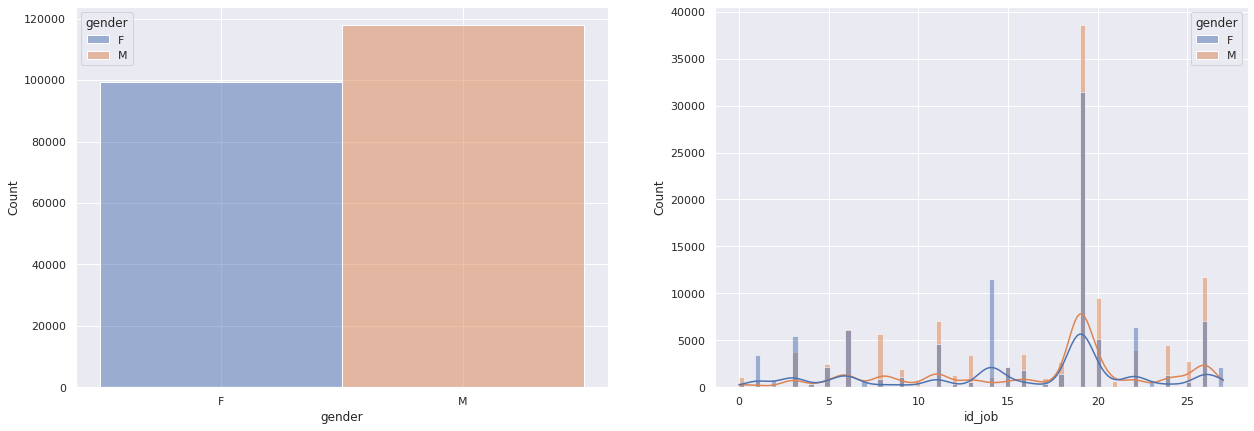

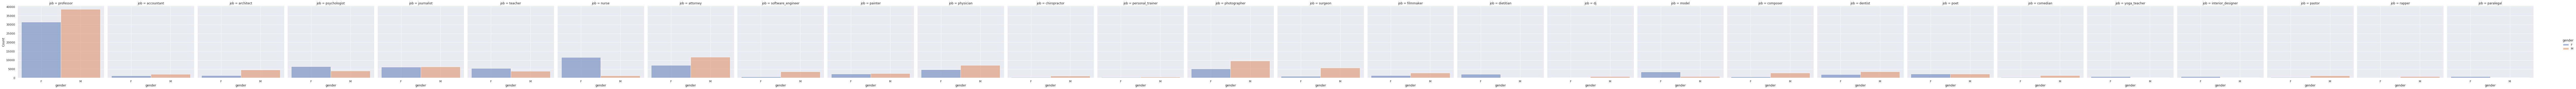

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(21, 7), sharey=False)
sns.histplot(data=df, x="gender", hue="gender", ax=axes[0])
sns.histplot(data=df, x="id_job", hue="gender", ax=axes[1], kde=True)
sns.displot(data=df, x="gender", hue="gender", col="job")

In [64]:
gender_gap_max = 0
for i in range(df_job.id_job.max()+1) :
    this_job = df[(df["id_job"]==i)]
    gap = (this_job[this_job.gender=="F"].gender.value_counts()/this_job.gender.value_counts().sum()).F - (this_job[this_job.gender=="M"].gender.value_counts()/this_job.gender.value_counts().sum()).M
    if abs(gap) >= gender_gap_max :
        gender_gap_max = gap

job_gap_max = (df.job.value_counts().max()/df.job.value_counts().sum()) - (df.job.value_counts().min()/df.job.value_counts().sum())


gender_ratio = df[df.gender=="F"].gender.value_counts().F/df[df.gender=="M"].gender.value_counts().M

d = {
     'Set': 'RAW',
     'Set-score': job_gap_max + gender_ratio + gender_gap_max,
     'Job Proportion Max Gap': job_gap_max,
     'Female/Male Ratio': gender_ratio,
     'Female/Male per Job Max Gap': gender_gap_max
}
info_sex = pd.DataFrame(d, index=[0])
df_info_genre = pd.concat([df_info_genre,info_sex])

In [65]:
info_sex

Set  Set-score  Job Proportion Max Gap  Female/Male Ratio  \
0  RAW    2.01329                0.318757           0.841386   

   Female/Male per Job Max Gap  
0                     0.853147

#### `02.b.` Dataframe équilibré en proportion de CV par métier

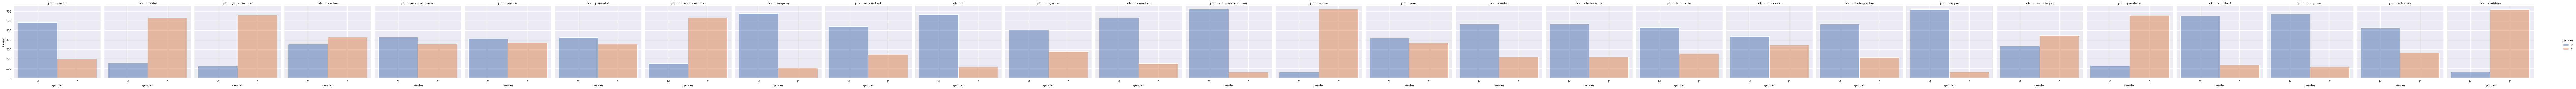

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(21, 7), sharey=False)
sns.histplot(data=df_eq, x="gender", hue="gender", ax=axes[0])
sns.histplot(data=df_eq, x="id_job", hue="gender", ax=axes[1], kde=True)
sns.displot(data=df_eq, x="gender", hue="gender", col="job")

In [67]:
gender_gap_max = 0
for i in range(df_job.id_job.max()+1) :
    this_job = df_eq[(df_eq["id_job"]==i)]
    gap = (this_job[this_job.gender=="F"].gender.value_counts()/this_job.gender.value_counts().sum()).F - (this_job[this_job.gender=="M"].gender.value_counts()/this_job.gender.value_counts().sum()).M
    if abs(gap) >= gender_gap_max :
        gender_gap_max = gap

job_gap_max = (df_eq.job.value_counts().max()/df_eq.job.value_counts().sum()) - (df_eq.job.value_counts().min()/df_eq.job.value_counts().sum())


gender_ratio = df_eq[df_eq.gender=="F"].gender.value_counts().F/df_eq[df_eq.gender=="M"].gender.value_counts().M

d = {
     'Set': 'EQI',
     'Set-score': job_gap_max + gender_ratio + gender_gap_max,
     'Job Proportion Max Gap': job_gap_max,
     'Female/Male Ratio': gender_ratio,
     'Female/Male per Job Max Gap': gender_gap_max
}
info_sex = pd.DataFrame(d, index=[0])
df_info_genre = pd.concat([df_info_genre,info_sex])

In [68]:
info_sex

Set  Set-score  Job Proportion Max Gap  Female/Male Ratio  \
0  EQI   1.582533                     0.0           0.738344   

   Female/Male per Job Max Gap  
0                     0.844189

#### `02.c.` Dataframe respectant la parité voulu plus équilibré en proportion de CV par métier 

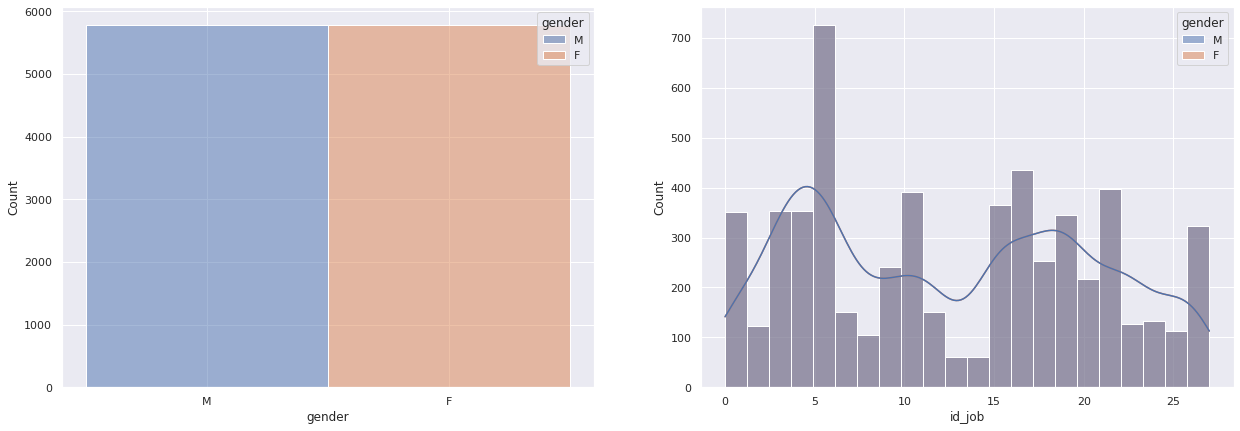

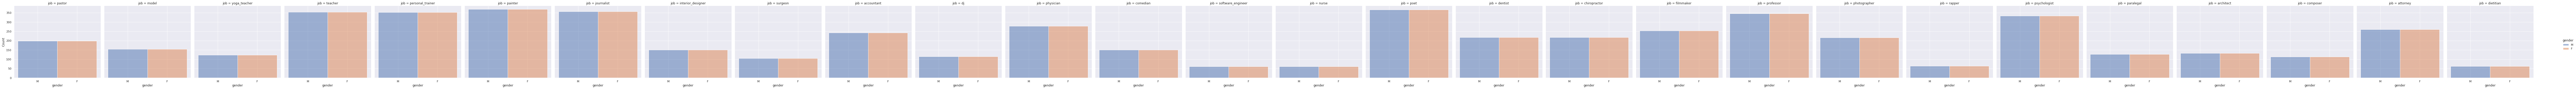

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(21, 7), sharey=False)
sns.histplot(data=df_min_parity, x="gender", hue="gender", ax=axes[0])
sns.histplot(data=df_min_parity, x="id_job", hue="gender", ax=axes[1], kde=True)
sns.displot(data=df_min_parity, x="gender", hue="gender", col="job")

In [70]:
gender_gap_max = 0
for i in range(df_job.id_job.max()+1) :
    this_job = df_min_parity[(df_min_parity["id_job"]==i)]
    gap = (this_job[this_job.gender=="F"].gender.value_counts()/this_job.gender.value_counts().sum()).F - (this_job[this_job.gender=="M"].gender.value_counts()/this_job.gender.value_counts().sum()).M
    if abs(gap) >= gender_gap_max :
        gender_gap_max = gap

job_gap_max = (df_min_parity.job.value_counts().max()/df_min_parity.job.value_counts().sum()) - (df_min_parity.job.value_counts().min()/df_min_parity.job.value_counts().sum())


gender_ratio = df_min_parity[df_min_parity.gender=="F"].gender.value_counts().F/df_min_parity[df_min_parity.gender=="M"].gender.value_counts().M

d = {
     'Set': 'MIP',
     'Set-score': job_gap_max + gender_ratio + gender_gap_max,
     'Job Proportion Max Gap': job_gap_max,
     'Female/Male Ratio': gender_ratio,
     'Female/Male per Job Max Gap': gender_gap_max
}
info_sex = pd.DataFrame(d, index=[0])
df_info_genre = pd.concat([df_info_genre,info_sex])

In [71]:
info_sex

Set  Set-score  Job Proportion Max Gap  Female/Male Ratio  \
0  MIP   1.053269                0.053269                1.0   

   Female/Male per Job Max Gap  
0                          0.0

#### `02.d.` Dataframe respectant la parité

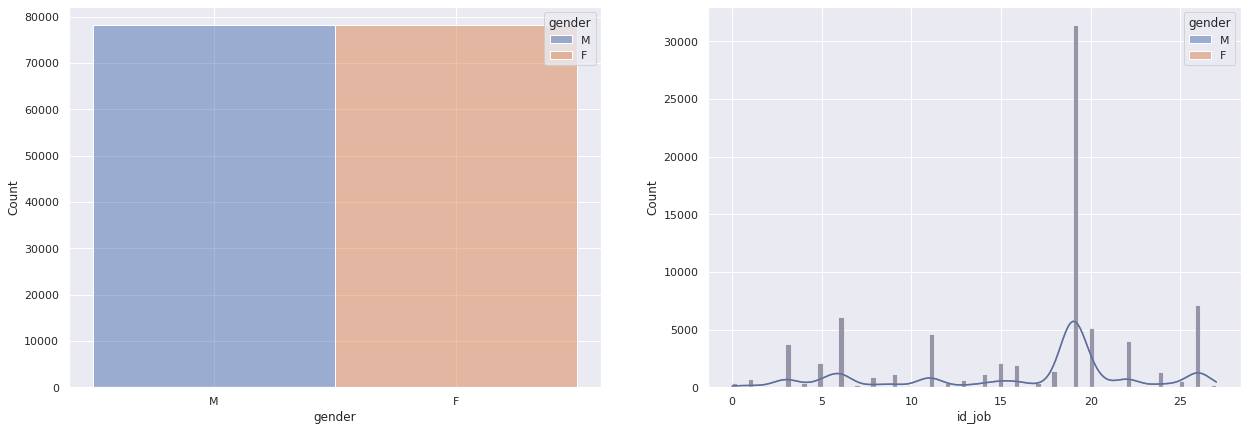

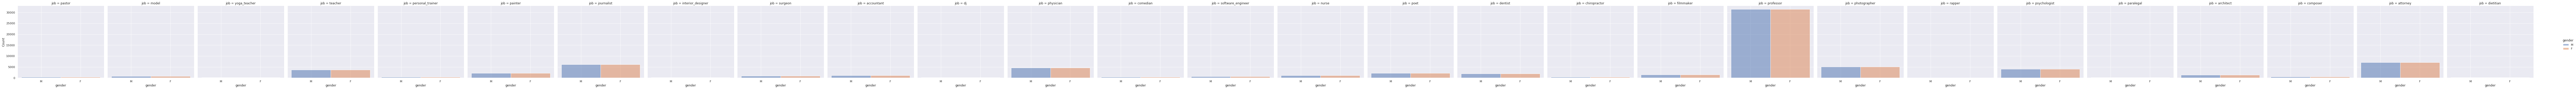

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(21, 7), sharey=False)
sns.histplot(data=df_parity, x="gender", hue="gender", ax=axes[0])
sns.histplot(data=df_parity, x="id_job", hue="gender", ax=axes[1], kde=True)
sns.displot(data=df_parity, x="gender", hue="gender", col="job")

In [73]:
gender_gap_max = 0
for i in range(df_job.id_job.max()+1) :
    this_job = df_parity[(df_parity["id_job"]==i)]
    gap = (this_job[this_job.gender=="F"].gender.value_counts()/this_job.gender.value_counts().sum()).F - (this_job[this_job.gender=="M"].gender.value_counts()/this_job.gender.value_counts().sum()).M
    if abs(gap) >= gender_gap_max :
        gender_gap_max = gap

job_gap_max = (df_parity.job.value_counts().max()/df_parity.job.value_counts().sum()) - (df_parity.job.value_counts().min()/df_parity.job.value_counts().sum())


gender_ratio = df_parity[df_parity.gender=="F"].gender.value_counts().F/df_parity[df_parity.gender=="M"].gender.value_counts().M

d = {
     'Set': 'PAR',
     'Set-score': job_gap_max + gender_ratio + gender_gap_max,
     'Job Proportion Max Gap': job_gap_max,
     'Female/Male Ratio': gender_ratio,
     'Female/Male per Job Max Gap': gender_gap_max
}
info_sex = pd.DataFrame(d, index=[0])
df_info_genre = pd.concat([df_info_genre,info_sex])

In [74]:
info_sex

Set  Set-score  Job Proportion Max Gap  Female/Male Ratio  \
0  PAR   1.400818                0.400818                1.0   

   Female/Male per Job Max Gap  
0                          0.0

#### `02.e.` Dataframe équilibré en proportion de CV par métier et par genre

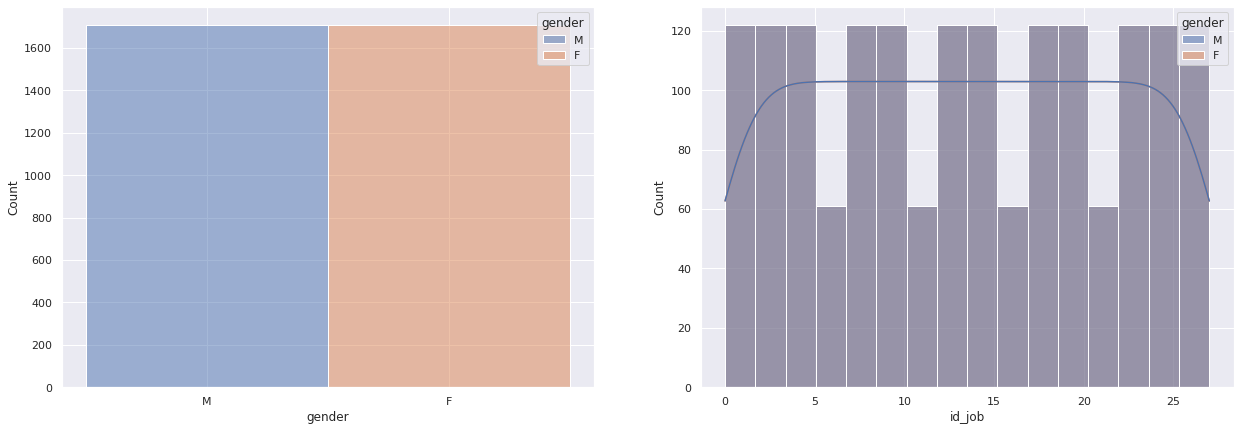

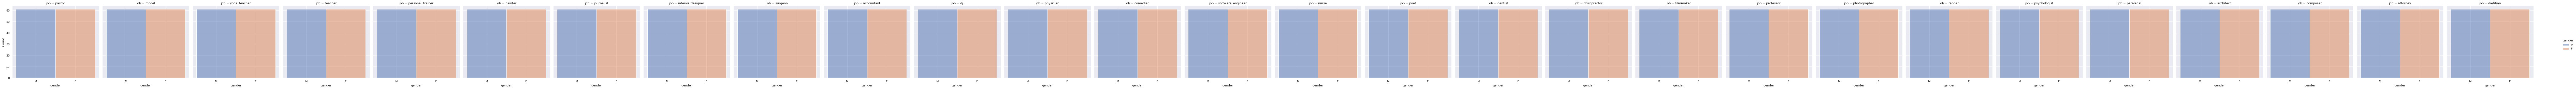

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(21, 7), sharey=False)
sns.histplot(data=df_eq_parity, x="gender", hue="gender", ax=axes[0])
sns.histplot(data=df_eq_parity, x="id_job", hue="gender", ax=axes[1], kde=True)
sns.displot(data=df_eq_parity, x="gender", hue="gender", col="job")

In [76]:
gender_gap_max = 0
for i in range(df_job.id_job.max()+1) :
    this_job = df_eq_parity[(df_eq_parity["id_job"]==i)]
    gap = (this_job[this_job.gender=="F"].gender.value_counts()/this_job.gender.value_counts().sum()).F - (this_job[this_job.gender=="M"].gender.value_counts()/this_job.gender.value_counts().sum()).M
    if abs(gap) >= gender_gap_max :
        gender_gap_max = gap

job_gap_max = (df_eq_parity.job.value_counts().max()/df_eq_parity.job.value_counts().sum()) - (df_eq_parity.job.value_counts().min()/df_eq_parity.job.value_counts().sum())


gender_ratio = df_eq_parity[df_eq_parity.gender=="F"].gender.value_counts().F/df_eq_parity[df_eq_parity.gender=="M"].gender.value_counts().M

d = {
     'Set': 'EQP',
     'Set-score': job_gap_max + gender_ratio + gender_gap_max,
     'Job Proportion Max Gap': job_gap_max,
     'Female/Male Ratio': gender_ratio,
     'Female/Male per Job Max Gap': gender_gap_max
}
info_sex = pd.DataFrame(d, index=[0])
df_info_genre = pd.concat([df_info_genre,info_sex])

In [77]:
info_sex

Set  Set-score  Job Proportion Max Gap  Female/Male Ratio  \
0  EQP        1.0                     0.0                1.0   

   Female/Male per Job Max Gap  
0                          0.0

In [80]:
df_info_genre

Set  Set-score  Job Proportion Max Gap  Female/Male Ratio  \
0  RAW   2.013290                0.318757           0.841386   
0  EQI   1.582533                0.000000           0.738344   
0  MIP   1.053269                0.053269           1.000000   
0  PAR   1.400818                0.400818           1.000000   
0  EQP   1.000000                0.000000           1.000000   

   Female/Male per Job Max Gap  
0                     0.853147  
0                     0.844189  
0                     0.000000  
0                     0.000000  
0                     0.000000

### `03.` Export des dataframes en pickles
On va pouvoir passer au notebook suivant en y important nos dataframes nouvellement formés.

In [78]:
now = dt.datetime.now()
datm = "{}{}{}{}{}{}".format(now.year,now.month,now.day,now.hour,now.minute,now.second)

In [20]:
# Dataframe brut - df
with open(f'{path}0. Dataframes/Pickles/{datm}.df.pickle', 'wb') as output:
    pickle.dump(df, output)

# Dataframe équilibré en proportion de CV par métier - df_eq
with open(f'{path}0. Dataframes/Pickles/{datm}.df_eq.pickle', 'wb') as output:
    pickle.dump(df_eq, output)

# Dataframe équilibré par genre et minimal en proportion de CV par métier - df_min_parity
with open(f'{path}0. Dataframes/Pickles/{datm}.df_min_parity.pickle', 'wb') as output:
    pickle.dump(df_min_parity, output)

# Dataframe équilibré en proportion de CV par métier et par genre - df_eq_parity
with open(f'{path}0. Dataframes/Pickles/{datm}.df_eq_parity.pickle', 'wb') as output:
    pickle.dump(df_eq_parity, output)

# Dataframe équilibré en proportion de CV par genre - df_parity
with open(f'{path}0. Dataframes/Pickles/{datm}.df_parity.pickle', 'wb') as output:
    pickle.dump(df_parity, output)

In [21]:
# Dataframe de toutes les catégories de métiers - df_job
with open(f'{path}0. Dataframes/Pickles/{datm}.df_job.pickle', 'wb') as output:
    pickle.dump(df_job, output)

In [79]:
# Dataframe d'information sur la répartition par genre des sets de données - df_info_genre
with open(f'{path}0. Dataframes/Pickles/{datm}.df_info_genre.pickle', 'wb') as output:
    pickle.dump(df_info_genre, output)

### `04.` Sources
* [Visualisation Seaborn](https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)